## Imports 

In [12]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# General
import numpy as np
import pandas as pd 
from random import *

# SK general 
from sklearn import model_selection
from sklearn import datasets
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# AutoML Libraries tpot and auto-sklearn
from tpot import TPOTClassifier
# from autosklearn.classification import AutoSklearnClassifier

#Plot
import matplotlib.pyplot as plt
import seaborn as sns

## Simulated Annealing

In [10]:
# Simulated Annealing function steps
# @parameters 
# sol - random solution (ML model)
# X_train, y_train - training data
# X_test, y_test - testing data
# @return solution and cost

# 1. Generate a random solution
# 2. Calculate its cost using a cost function (accuracy of the ML Model)
# 3. Generate a random neigboring solution
# 4. Calculate new solutions cost (accuracy of the ML model)
# 5. Compare solutions
#     - If c_new > c_old move to the new solution
#     - If c_new < c_old maybe move to the new solution
# 6. Repeat steps until an acceptable solution is found or max number of iterations is reached
def sa(sol, X_train, y_train, X_test, y_test):
    t = 1.0
    t_min = 0.00001
    alpha = 0.9
    old_cost = cost(sol, X_train, y_train, X_test, y_test)
    while t > t_min:
        i = 1
        while i <= 100:
            new_sol = neighbor(sol)
            new_cost = cost(new_sol, X_train, y_train, X_test, y_test)
            ap = acceptance_probability(old_cost, new_cost, t)
            rnd = random()
            # print(ap, rnd)
            if ap > rnd:
                sol = new_sol
                old_cost = new_cost
            i += 1
        t = t * alpha
    return sol, old_cost          

In [11]:
# Function to generate neighboring solution
# Solution is defined as a machine learning model along with a set of parameters
# i.e.,
# solution = {
#     model: 'LinearRegression',
#     parameters: {
#         fit_intercept: true,
#         normalize: true,
#         copy_X: false,
#         n_jobs: 4,
#     }
# }
def neighbor(sol):
    # Use the search_space to find a new neighbor of the current solution and return that
    
    # Chose a random parameter and modify it 
    parameter = choice(list(search_space[sol['name']].keys())) # random.choice()
    # print('Selected parameter ', parameter)
    
    parameter_is_tuple = type(search_space[sol['name']][parameter]) is tuple
    
    if parameter_is_tuple:
        parameter_space = search_space[sol['name']][parameter][0]
    else:
        parameter_space = search_space[sol['name']][parameter]
    # print('Parameter space', parameter_space)
    
    # Grab the random parameter from our current solution and change it
    if parameter_is_tuple:
        current_parameter_val = sol['parameters'][parameter][0]
    else:
        current_parameter_val = sol['parameters'][parameter]
    # print('Current parameter value', current_parameter_val)
    
    # Grab the current index of the selected parameter of our model
    current_index = parameter_space.index(current_parameter_val)
    
    # In one step modify the value of the selected parameter
    if current_index == 0:
        # index = 0 -> index++
        if parameter_is_tuple:
            modified_parameter = (parameter_space[1],)
        else:
            modified_parameter = parameter_space[1];
    elif current_index == len(parameter_space):
        # index = length -> index--
        if parameter_is_tuple:
            modified_parameter = (parameter_space[current_index - 1],)
        else:
            modified_parameter = parameter_space[current_index - 1]
    else: 
        # index = index + random(-1,1)
        if parameter_is_tuple:
             modified_parameter = (parameter_space[(current_index + choice([-1, 1])) % len(parameter_space)],)
        else:
            modified_parameter = parameter_space[(current_index + choice([-1, 1])) % len(parameter_space)]
    
    # Create a new solution copy the current one and replace the randomly chosen parameter
    new_sol = sol
    new_sol['parameters'][parameter] = modified_parameter
    
    # print('New parameter value', modified_parameter)
    
    # Return new neighboring solution
    return new_sol

In [12]:
# Function to return the cost of a current solution
# In our case the cost is the accuracy (or we can use other metrics) of the current ML model / parameter configuration
# TODO: RMSE or some other metric?
def cost(sol, X_train, y_train, X_test, y_test): 
    # Get model
    model = get_model(sol['name'], sol['parameters'])
    
    # Train model on data
    model.fit(X_train, y_train)
    
    # Predictions
    # predictions = model.predict(X_test)
    
    # Get accuracy or some other metric and return
    score = model.score(X_test, y_test)
    # print('Score: ', score)
    return score

In [13]:
# Function to get a model with a parameter configuration
def get_model(name, parameters):
    # LogisticRegression
    if name == 'LogisticRegression':
        lr = LogisticRegression(**parameters)
        return lr
    # Model2
    elif name == 'MLPClassifier':
        abc = MLPClassifier(**parameters)
        return abc
    # Model3
    elif name == 'SGDClassifier':
        sgd = SGDClassifier(**parameters)
        return sgd
    # Model4
    elif name == 'SVC':
        svc = SVC(**parameters)
        return svc
    # Model5
    elif name == 'RandomForestClassifier':
        rfc = RandomForestClassifier(**parameters)
        return rfc
    # Default
    else:
        print('No model provided')
        return

In [14]:
# Function which recommends if we should jump to a new solutions or not
# 1.0 - definitely switch
# 0.0 - definitely stay put
# 0.5 - 50/50 odds of switching
# Usually calculated by e^((c_new - c_old)/t)

def acceptance_probability(old_cost, new_cost, t): 
    if new_cost >= old_cost:
        return 1.0
    else:
        return np.exp((new_cost - old_cost)/t)

## ML Models

In [15]:
# Search Space that will be used to define our neighborhood of ML models and hyperparameters
# Basically our dictionary defining the model, its most important parameters, and their value ranges
search_space = {
    'LogisticRegression': {
        'penalty': ['l1', 'l2'],
        'C': np.logspace(-4, 4, 20).tolist(),
        'solver': ['liblinear', 'saga'],
    },
    'MLPClassifier': {
        'hidden_layer_sizes': (np.arange(1, 100, 1).tolist(), ),
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'alpha': np.logspace(-4, 1, 10).tolist(),
        'learning_rate': ['constant', 'invscaling', 'adaptive'],       
    },
    'SGDClassifier': {
        'penalty': ['l1', 'l2', 'elasticnet'],
        'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
        'alpha': np.logspace(-4, 1, 10).tolist(),
        'eta0': np.logspace(-4, 1, 10).tolist(),
        'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
    },
    'SVC': {
        'C': np.logspace(-4, 1, 10).tolist(),
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto'],
    },
    'RandomForestClassifier': {
        'n_estimators': np.arange(1, 100, 1).tolist(),
        'criterion': ['gini', 'entropy'],
        'max_depth': np.arange(2, 50, 1).tolist(),
        'min_samples_split': np.arange(0.1, 1.1, 0.1).tolist()
    }
}

## Datasets

In [8]:
# Iris
iris = datasets.load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [14]:
# Handwritten Digits
digits = datasets.load_digits()
X = digits.data
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [4]:
# Wine Quality Data 3
wwine = pd.read_csv("./data/winequality-white.csv", sep=';')
labels = ["poor", "average", "excellent"]
wwine['class'] = pd.cut(wwine['quality'], bins = 3, labels = labels)
wwine['class'] = pd.cut(wwine['quality'], bins = 3, labels = False)

X = wwine[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar','chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']]
y = wwine['class']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.33,random_state=123)

# standadise
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [3]:
#Glass Classification Dataset
#read data
data = pd.read_csv("glass.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
RI      214 non-null float64
Na      214 non-null float64
Mg      214 non-null float64
Al      214 non-null float64
Si      214 non-null float64
K       214 non-null float64
Ca      214 non-null float64
Ba      214 non-null float64
Fe      214 non-null float64
Type    214 non-null int64
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [5]:
data.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [6]:
data.isnull().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

In [7]:
data.mean()

RI       1.518365
Na      13.407850
Mg       2.684533
Al       1.444907
Si      72.650935
K        0.497056
Ca       8.956963
Ba       0.175047
Fe       0.057009
Type     2.780374
dtype: float64

In [8]:
data

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


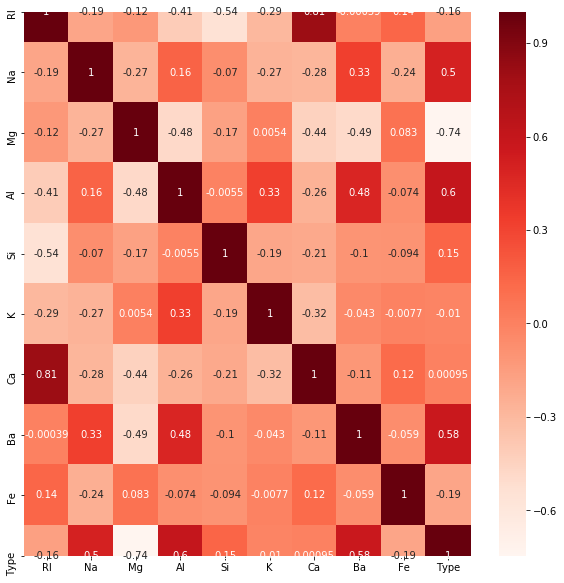

In [13]:
#Correlation table
plt.figure(figsize=(10,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [14]:
#trim
X=data.drop(['Type'], axis=1)
y=data['Type']

In [15]:
#train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [16]:
X_train.shape, X_test.shape, data.shape

((149, 9), (65, 9), (214, 10))

## Evaluation

In [17]:
# Some random solution that we will pass to the sa() to start with
models = []

# LogisticRegression
models.append({
    'name': 'LogisticRegression',
    'parameters': {
        'penalty': 'l2',
        'C': 0.23357214690901212,
        'solver': 'liblinear',
        'n_jobs': -1
    }
})

# MLPClassifier
models.append({
    'name': 'MLPClassifier',
    'parameters': {
        'hidden_layer_sizes': (1,),
        'activation': 'relu',
        'solver': 'adam',
        'alpha': 0.0001,
        'learning_rate': 'constant',       
    }
})

# # SGDClassifier
models.append({
    'name': 'SGDClassifier',
    'parameters': {
        'penalty': 'l1',
        'loss': 'hinge',
        'alpha': 0.0001,
        'eta0': 0.0001,
        'learning_rate': 'constant'
    }
})

# # SVC
models.append({
    'name': 'SVC',
    'parameters': {
        'C': 0.0001,
        'kernel': 'linear',
        'gamma': 'scale',
    }
})

# RandomForest
models.append({
    'name': 'RandomForestClassifier',
    'parameters': {
        'n_estimators': 1,
        'criterion': 'gini',
        'max_depth': 2,
        'min_samples_split': 0.1,
    }
})

In [18]:
# Save all solutions
solutions = []

# Save best solution
best_solution = {
    'solution': '',
    'score': 0
}

# Iterate over models and get the best solution / score
for i in models:
    solution, score = sa(i, X_train, y_train, X_test, y_test)
    print('Done with ', solution['name'])
    solutions.append({
       'solution': solution,
       'score': score
    })
    
    if score > best_solution['score']:
        best_solution = {
            'solution': solution,
            'score': score
        }
    
# Print results
print('Best solution: ', best_solution)
print('All solutions', solutions)

Done with  LogisticRegression
Done with  MLPClassifier
Done with  SGDClassifier
Done with  SVC
Done with  RandomForestClassifier
Best solution:  {'solution': {'name': 'MLPClassifier', 'parameters': {'hidden_layer_sizes': (68,), 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.016681005372000592, 'learning_rate': 'constant'}}, 'score': 0.7520098948670377}
All solutions [{'solution': {'name': 'LogisticRegression', 'parameters': {'penalty': 'l1', 'C': 10000.0, 'solver': 'liblinear', 'n_jobs': -1}}, 'score': 0.7235621521335807}, {'solution': {'name': 'MLPClassifier', 'parameters': {'hidden_layer_sizes': (68,), 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.016681005372000592, 'learning_rate': 'constant'}}, 'score': 0.7520098948670377}, {'solution': {'name': 'SGDClassifier', 'parameters': {'penalty': 'l1', 'loss': 'squared_loss', 'alpha': 0.004641588833612782, 'eta0': 0.0001, 'learning_rate': 'invscaling'}}, 'score': 0.7309833024118738}, {'solution': {'name': 'SVC', 'parameters'

## TPOT

In [6]:
# Get TPOT classification optimizer
tpot_automl_d = TPOTClassifier(generations = 5, population_size = 20, cv = 5, random_state = 42, n_jobs = -1)

# Fit on dataset
tpot_automl_d.fit(X_train, y_train)

# Get score
print('Score: ', tpot_automl_d.score(X_test, y_test))
tpot_automl.export('tpot_whitewine_pipeline.py')
# tpot_automl.export('tpot_iris_pipeline.py')
# tpot_automl.export('tpot_digits_pipeline.py')
# tpot_automl.export('tpot_glass_pipeline.py')

Score:  0.769325912183055


## Auto-sklearn

In [12]:
# Get auto-sklearn classifier
sklearn_automl = AutoSklearnClassifier()

# Fit on dataset
sklearn_automl.fit(X_train, y_train)

# y_hat = sklearn_automl.predict(X_test)

# Get score
print('Score: ', sklearn_automl.score(X_test, y_test))
print(sklearn_automl.sprint_statistics())
print(sklearn_automl.show_models())

[WARNING] [2020-01-24 10:36:47,651:EnsembleBuilder(1):ed217d05461c6dff1ebbcd34c23a0766] No models better than random - using Dummy Score!
[WARNING] [2020-01-24 10:36:47,671:EnsembleBuilder(1):ed217d05461c6dff1ebbcd34c23a0766] No models better than random - using Dummy Score!
Score:  1.0
auto-sklearn results:
  Dataset name: ed217d05461c6dff1ebbcd34c23a0766
  Metric: accuracy
  Best validation score: 0.971429
  Number of target algorithm runs: 3168
  Number of successful target algorithm runs: 2928
  Number of crashed target algorithm runs: 240
  Number of target algorithms that exceeded the time limit: 0
  Number of target algorithms that exceeded the memory limit: 0

[(1.000000, SimpleClassificationPipeline({'balancing:strategy': 'none', 'categorical_encoding:__choice__': 'no_encoding', 'classifier:__choice__': 'k_nearest_neighbors', 'imputation:strategy': 'mean', 'preprocessor:__choice__': 'liblinear_svc_preprocessor', 'rescaling:__choice__': 'minmax', 'classifier:k_nearest_neighbors

In [17]:
# Get auto-sklearn classifier
sklearn_automl_d = AutoSklearnClassifier()

# Fit on dataset
sklearn_automl_d.fit(X_train, y_train)

# y_hat = sklearn_automl.predict(X_test)

# Get score
print('Score: ', sklearn_automl_d.score(X_test, y_test))
print(sklearn_automl_d.sprint_statistics())
print(sklearn_automl_d.show_models())

[WARNING] [2020-01-25 12:22:57,006:EnsembleBuilder(1):4676db1ef6ee2b6c4653d6fe3ca88713] No models better than random - using Dummy Score!
[WARNING] [2020-01-25 12:22:57,035:EnsembleBuilder(1):4676db1ef6ee2b6c4653d6fe3ca88713] No models better than random - using Dummy Score!
Score:  0.9888888888888889
auto-sklearn results:
  Dataset name: 4676db1ef6ee2b6c4653d6fe3ca88713
  Metric: accuracy
  Best validation score: 0.985542
  Number of target algorithm runs: 182
  Number of successful target algorithm runs: 160
  Number of crashed target algorithm runs: 17
  Number of target algorithms that exceeded the time limit: 5
  Number of target algorithms that exceeded the memory limit: 0

[(0.120000, SimpleClassificationPipeline({'balancing:strategy': 'none', 'categorical_encoding:__choice__': 'one_hot_encoding', 'classifier:__choice__': 'adaboost', 'imputation:strategy': 'most_frequent', 'preprocessor:__choice__': 'polynomial', 'rescaling:__choice__': 'minmax', 'categorical_encoding:one_hot_en

## Results

In [ ]:
# Iris data output
# Done with  LogisticRegression
# Done with  MLPClassifier
# Done with  SGDClassifier
# Done with  SVC
# Done with  RandomForestClassifier
# Best solution
iris_best = {
    'solution': {
        'name': 'LogisticRegression', 
        'parameters': {
            'penalty': 'l2', 
            'C': 0.0018329807108324356, 
            'solver': 'saga', 
            'n_jobs': -1
        }
    }, 
    'score': 1.0
}
#All solutions
iris_all = [{
    'solution': {
        'name': 'LogisticRegression', 
        'parameters': {
            'penalty': 'l2', 
            'C': 0.0018329807108324356, 
            'solver': 'saga', 
            'n_jobs': -1
        }
    }, 
    'score': 1.0
}, 
{
    'solution': {
        'name': 'MLPClassifier', 
        'parameters': {
            'hidden_layer_sizes': (48,), 
            'activation': 'tanh', 
            'solver': 'sgd', 
            'alpha': 0.05994842503189409, 
            'learning_rate': 'constant'
        }
    }, 
    'score': 1.0
}, 
{
    'solution': {
        'name': 'SGDClassifier', 
        'parameters': {
            'penalty': 'l1', 
            'loss': 'modified_huber', 
            'alpha': 0.001291549665014884, 
            'eta0': 0.0001, 
            'learning_rate': 'adaptive'
        }
    }, 
    'score': 1.0
}, 
{
    'solution': {
        'name': 'SVC', 
     'parameters': {
         'C': 0.05994842503189409, 
         'kernel': 'poly', 
         'gamma': 'scale'
     }
    }, 
    'score': 1.0
}, 
{
    'solution': {
        'name': 'RandomForestClassifier', 
        'parameters': {
             'n_estimators': 82, 
             'criterion': 'gini', 
             'max_depth': 9, 
             'min_samples_split': 0.1
        }
    }, 
    'score': 1.0
}]

In [ ]:
# Digits dataset output
digits_best =  {
    'solution': {
        'name': 'SVC', 
        'parameters': {
            'C': 0.00035938136638046257, 
            'kernel': 'poly', 
            'gamma': 'scale'
        }
    }, 
    'score': 0.9907407407407407
}

digits_all = [{
    'solution': {
        'name': 'LogisticRegression', 
        'parameters': {
            'penalty': 'l2', 
            'C': 0.00026366508987303583, 
            'solver': 'saga', 
            'n_jobs': -1
        }
    }, 
    'score': 0.9722222222222222
}, {
    'solution': {
        'name': 'MLPClassifier', 
        'parameters': {
            'hidden_layer_sizes': (15,), 
            'activation': 'tanh', 
            'solver': 'sgd', 
            'alpha': 0.00035938136638046257, 
            'learning_rate': 'adaptive'
        }
    }, 
    'score': 0.987037037037037
}, {
    'solution': {
        'name': 'SGDClassifier', 
        'parameters': {
            'penalty': 'elasticnet', 
            'loss': 'hinge', 
            'alpha': 0.00035938136638046257, 
            'eta0': 0.001291549665014884, 
            'learning_rate': 'constant'
        }
    }, 
    'score': 0.9740740740740741
}, {
    'solution': {
        'name': 'SVC', 
        'parameters': {
            'C': 0.00035938136638046257, 
            'kernel': 'poly', 
            'gamma': 'scale'
        }
    }, 
    'score': 0.9907407407407407
}, {
    'solution': {
        'name': 'RandomForestClassifier', 
        'parameters': {
            'n_estimators': 16, 
            'criterion': 'gini', 
            'max_depth': 15, 
            'min_samples_split': 0.2
        }
    }, 
    'score': 0.9055555555555556
}]

In [ ]:
# White Wine Dataset
Whitewine_best_solution = { 
    'solution': { 
        'name': 'MLPClassifier', 
        'parameters': { 
            'hidden_layer_sizes': (68), 
            'activation': 'logistic', 
            'solver': 'sgd', 
            'alpha': 0.016681005372000592, 
            'learning_rate': 'constant' 
        }
    }, 
    'score': 0.7520098948670377 
}

Whitewine_all_solutions = [
    { 
        'solution': { 
            'name': 'LogisticRegression', 
            'parameters': { 
                'penalty': 'l1', 
                'C': 10000.0, 'solver': 
                'liblinear', 'n_jobs': -1 
            } 
        }, 
        'score': 0.7235621521335807 
    }, 
    { 
        'solution': { 
            'name': 'MLPClassifier', 
            'parameters': { 
                'hidden_layer_sizes': (68), 
                'activation': 'logistic', 
                'solver': 'sgd', 
                'alpha': 0.016681005372000592, 
                'learning_rate': 'constant' 
            } 
        }, 
        'score': 0.7520098948670377 
    }, 
    { 
        'solution': { 
            'name': 'SGDClassifier', 
            'parameters': { 
                'penalty': 'l1', 
                'loss': 'squared_loss', 
                'alpha': 0.004641588833612782, 
                'eta0': 0.0001, 
                'learning_rate': 'invscaling' 
            } 
        }, 
        'score': 0.7309833024118738 
    }, 
    { 
        'solution': { 
            'name': 'SVC', 
            'parameters': { 
                'C': 0.001291549665014884, 
                'kernel': 'poly', 
                'gamma': 'auto' 
            } 
        }, 
        'score': 0.7421150278293135 
    }, 
    { 
        'solution': { 
            'name': 'RandomForestClassifier', 
            'parameters': { 
                'n_estimators': 28, 
                'criterion': 'gini', 
                'max_depth': 15, 
                'min_samples_split': 0.1 
            } 
        }, 
        'score': 0.7396413110698825 
    }
]

# TPot Score
Score = "0.769325912183055"

In [20]:
# Glass data output
# Done with  LogisticRegression
# Done with  MLPClassifier
# Done with  SGDClassifier
# Done with  SVC
# Done with  RandomForestClassifier
# Best solution
glass_best = {'solution': {
    'name': 'RandomForestClassifier', 
    'parameters': {
        'n_estimators': 2, 
        'criterion': 'entropy', 
        'max_depth': 2, 
        'min_samples_split': 0.7000000000000001}},
              'score': 0.8}
#All solutions
glass_all = [
{'solution': 
 {'name': 'LogisticRegression', 
  'parameters': {
      'penalty': 'l1', 
      'C': 0.012742749857031334, 
      'solver': 'liblinear', 
      'n_jobs': -1}}, 
 'score': 0.6923076923076923}, 
    
{'solution': 
 {'name': 'MLPClassifier', 
  'parameters': {
      'hidden_layer_sizes': (33,), 
      'activation': 'relu', 
      'solver': 'sgd', 
      'alpha': 0.05994842503189409, 
      'learning_rate': 'constant'}}, 
 'score': 0.7384615384615385}, 
    
{'solution': 
 {'name': 'SGDClassifier', 
  'parameters': {
      'penalty': 'l2', 
      'loss': 'log', 
      'alpha': 0.21544346900318845, 
      'eta0': 2.782559402207126, 
      'learning_rate': 'invscaling'}}, 
 'score': 0.6461538461538462}, 
    
{'solution': {'name': 'SVC', 
              'parameters': {
                  'C': 0.7742636826811278, 
                  'kernel': 'rbf', 
                  'gamma': 'auto'}}, 
 'score': 0.7384615384615385}, 
    
{'solution': 
 {'name': 'RandomForestClassifier', 
  'parameters': {
      'n_estimators': 2, 
      'criterion': 'entropy', 
      'max_depth': 2, 
      'min_samples_split': 0.7000000000000001}}, 
 'score': 0.8}
]

#TPOT Score
Score:  0.8153846153846154
    

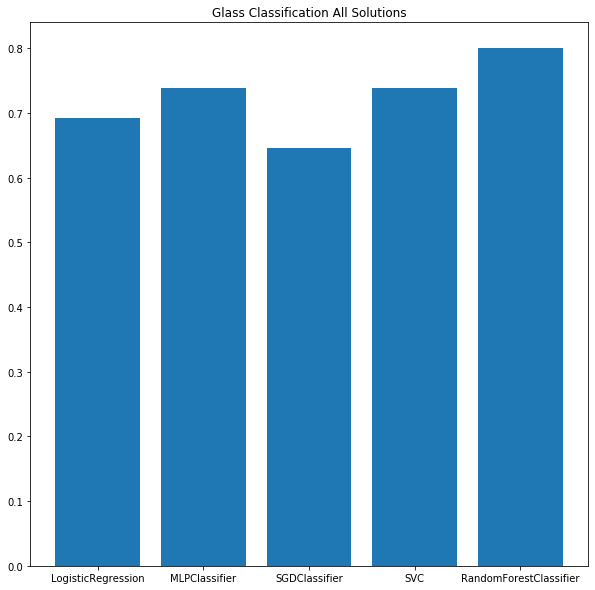

In [21]:
#Graphic module from Sam to visualize results output
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10,10))
ax.set_title('Glass Classification All Solutions')

D = {}
for x in glass_all:
    name = x['solution']['name']
    score = x['score']
    D[name] = score
plt.bar(range(len(D)), D.values(), align='center')
plt.xticks(range(len(D)), D.keys())

plt.show()